<a href="https://colab.research.google.com/github/sc22lg/ML-Notebooks/blob/paper_recreation/semantic_attention_recreation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Recreation of the Results of: The Self-Hating Attention Head: A Deep Dive in GPT-2 - Matteo Migliarini July 2025
by Leo Gott

Original publication can be found [here](https://www.lesswrong.com/posts/wxPvdBwWeaneAsWRB/the-self-hating-attention-head-a-deep-dive-in-gpt-2-1)

### Overall idea:
"gpt2-small's head L1H5 directs attention to semantically similar tokens and actively suppresses self-attention"
### Results to re-create:
- Create inputs to ellicit expected behaviour
- Use inputs to identify heads performing behaviour in gpt2-small (expected head L1H5)
- Perform mean-ablation of preceding components to find which components effect L1H5

### Setup:

In [1]:
import os
import sys
from pathlib import Path
import functools

import pkg_resources

installed_packages = [pkg.key for pkg in pkg_resources.working_set]
if "transformer-lens" not in installed_packages:
    %pip install transformer_lens==2.11.0 einops eindex-callum jaxtyping git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

import pandas as pd
import circuitsvis as cv
import einops
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from jaxtyping import Float, Int
from torch import Tensor
from transformer_lens import (
    ActivationCache,
    FactoredMatrix,
    HookedTransformer,
    HookedTransformerConfig,
    utils,
)
from transformer_lens.hook_points import HookPoint

/tmp/ipython-input-2356033099.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
import random as rand
import plotly.express as px
from IPython.display import display

### 1.1 Generate input prompt

In [3]:
semantic_words_file = pd.read_csv('semantic_words.csv', header=None)
print(semantic_words_file.to_string())

        0        1          2         3       4         5
0  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday
1     red     blue      green    silver   white      Blue
2    1918     1920       1930      1900    1998      2000
3     You       He        his       she     her     their
4   Italy    China    Austria    Mexico   Spain    France
5     dog      cat      horse      bird    fish       pig
6      60       65         69        70      71        90
7     car      bus        van     truck    bike     plane
8   chair    table       sofa      desk     bed     shelf
9   river     lake      ocean       sea    pond    stream


In [4]:
# Create shuffled list of tokens
n_sequences = 30
n_tokens = 12
n_rows = semantic_words_file.shape[0]

inputs = np.empty((n_sequences, n_tokens), dtype=tuple)
seed:int = 5 # seeds that work: 5
rnd = np.random.RandomState(seed)

for i in range(n_sequences):
  subset = semantic_words_file.sample(4, random_state = rnd)
  for j in range(n_tokens):
    category_list = subset.sample(1, random_state = rnd)
    category = category_list.index[0]
    token = category_list.iloc[0].sample(1, random_state = rnd).values[0]
    inputs[i, j] = (category, token)
# print(inputs)

### 1.2 Create Masks

In [5]:
#create masks representing where tokens in an input share a category
masks = np.zeros((n_sequences, n_tokens, n_tokens))

for seq in range(n_sequences):
  for i in range(n_tokens):
    for j in range(n_tokens):
      if inputs[seq, i][0] == inputs[seq, j][0] and inputs[seq, i][1] != inputs[seq, j][1] and i > j: # ensures upper triangle is 0s
        masks[seq, i, j] = 1

In [6]:
show_mask = 1
fig = px.imshow(masks[show_mask], labels=dict(x="Token Index", y="Token Index", color="Same Category")) # Added labels dictionary
fig.update_layout(xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(n_tokens)),
        ticktext = [inputs[show_mask, i][1] for i in range(n_tokens)] # Use tokens from inputs for x-axis
    ),
    yaxis = dict(
        tickmode = 'array',
        tickvals = list(range(n_tokens)),
        ticktext = [inputs[show_mask, i][1] for i in range(n_tokens)] # Use tokens from inputs for y-axis
    )
)
fig.show()

### 1.3 Load & test gpt2-small:

In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small", device="cpu")
print(model.cfg)

In [8]:
sequence_index = show_mask
string_inputs = []
token_inputs = []

#convert sequences to strings then tokens
for seq in range(n_sequences):
  string_inputs.append(' '.join([inputs[seq, i][1] for i in range(n_tokens)]))
  tokens = model.to_tokens(string_inputs[seq])
  token_inputs.append(tokens)

#print(token_inputs)

#remove invalid token sequences and masks by iterating in reverse
for i in range(len(token_inputs) - 1, -1, -1):
  if(len(token_inputs[i][0]) != n_tokens+1):
    del token_inputs[i]
    del string_inputs[i]
    masks = np.delete(masks, i, axis=0) # Delete the corresponding mask


#print(len(token_inputs))
for seq in token_inputs:
  print(len(seq.squeeze()))

#run model
input_tokens = token_inputs[sequence_index]
logits, cache = model.run_with_cache(input_tokens)

13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13


### 1.4 Display Attention Patterns

In [9]:
def display_attention_layer(cache: ActivationCache, layer_number: int, str_tokens: list):

  layer1_patterns = cache["pattern", layer_number]
  print(layer1_patterns.shape)

  display(
      cv.attention.attention_patterns(
          tokens=str_tokens,
          attention=layer1_patterns.squeeze(),
          attention_head_names=[f"L{layer_number}H{i}" for i in range(12)],
      )
  )

print(input_tokens.shape)
print(input_tokens.squeeze())
str_tokens = model.to_str_tokens(input_tokens.squeeze())
layer_number = 1
display_attention_layer(cache, layer_number, str_tokens)

torch.Size([1, 13])
tensor([50256, 14573,   607,   511,  4171,  6915,   679,  3431,  5118,  3996,
          921,   679, 18316])
torch.Size([1, 12, 13, 13])


### 1.5 Pattern detector:

In [10]:
print(f"layers: {model.cfg.n_layers}")
print(f"heads per layer: {model.cfg.n_heads}")

layers: 12
heads per layer: 12


In [11]:
def evaluate_semantic_head(cache: ActivationCache, layer:int, head:int):
  attention_pattern = cache["pattern", layer].squeeze()[head]
  expected_attention = attention_pattern[1:,1:][t.from_numpy(masks[sequence_index]).bool()] # slice attention to ignore |endoftext| and then apply mask
  return t.mean(expected_attention)

def semantic_head_detector(cache: ActivationCache):
  scores = np.zeros((model.cfg.n_layers, model.cfg.n_heads))

  # calculate attention score for current input for each attention head
  for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
      scores[layer, head] = evaluate_semantic_head(cache, layer, head)
  return scores


In [12]:
attn_head_scores = semantic_head_detector(cache)
fig = px.imshow(attn_head_scores, labels=dict(x="Head", y="Layer", color="Attention Score"))
fig.show()

## 1.6 Measuring Component importance:
In order to measure which components are contributing to the function of L1H5, we perform a mean ablation study. We replace each previous compenent of the network with its mean and re-measure the attention score of our metric for L1H5 to see if it was impacted by the ablation of that component. The components which when ablated has the most effect on the performance of L1H5 are the components which contribute to its function.

In [13]:
pos_embed_name = utils.get_act_name("pos")
print(model.W_pos.size())
print(model.hook_dict) # print hookpoint names

torch.Size([1024, 768])
{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.ln1.hook_scale': HookPoint(), 'blocks.0.ln1.hook_normalized': HookPoint(), 'blocks.0.ln2.hook_scale': HookPoint(), 'blocks.0.ln2.hook_normalized': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint(), 'bl

In [14]:
batch = 1
heads = model.cfg.n_heads
seq_len = n_tokens

### Example Hook Funciton

In [15]:
def hook_function(
    attn_pattern: Float[Tensor, "batch heads seq_len seq_len"],
    hook: HookPoint
) -> Float[Tensor, "batch heads seq_len seq_len"]:

    # modify attn_pattern (can be inplace)
    return attn_pattern

In [16]:
loss = model.run_with_hooks(
    input_tokens,
    return_type="loss",
    fwd_hooks=[
        ('blocks.1.attn.hook_pattern', hook_function)
    ]
)

### 1.7 Ablation hooks

In [17]:
ablated_head_scores = t.zeros(1)

def eval_head(attention_pattern, mask_index):
  expected_attention = attention_pattern[1:,1:][t.from_numpy(masks[mask_index]).bool()] # slice attention to ignore |endoftext| and then apply mask
  return t.mean(expected_attention)

#evaluate attention score @ head 1,5
def eval_attention_hook(
    attn_pattern: Float[Tensor, "batch heads seq_len seq_len"],
    hook: HookPoint,
    mask_index: int,
) -> Float[Tensor, "batch heads seq_len seq_len"]:
    global ablated_head_scores
    eval_score = eval_head(attn_pattern.squeeze()[5], mask_index)
    ablated_head_scores = t.cat((ablated_head_scores, eval_score.unsqueeze(dim=0)))
    return attn_pattern

#perform mean ablation on embedding layer
def embedding_ablation_hook(
    embed_output: Float[t.Tensor, "n_ctx d_model"],
    hook: HookPoint,
):
  # Ablate by replacing with the mean
  embed_output[:] = embed_output.mean(dim=1, keepdim=True)
  return embed_output

#perform mean ablation on attention layer
def attention_ablation_hook(
    attn_pattern: Float[Tensor, "batch heads seq_len seq_len"],
    hook: HookPoint
) -> Float[Tensor, "batch heads seq_len seq_len"]:

  attn_pattern[:] = attn_pattern.mean(dim=1, keepdim=True)
  return attn_pattern

#perform mean ablation on mlp layer
def mlp_ablation_hook(
    mlp_output: Float[t.Tensor, "n_ctx d_model"],
    hook: HookPoint,
) -> Float[Tensor, "n_ctx d_model"]:
  # Ablate by replacing with the mean
  mlp_output[:] = mlp_output.mean(dim=1, keepdim=True)
  return mlp_output


test_index = sequence_index
temp_hook_fn = functools.partial(eval_attention_hook, mask_index = test_index)
#run with no ablation
model.run_with_hooks(input_tokens, return_type = None, fwd_hooks = [('blocks.1.attn.hook_pattern', temp_hook_fn)], reset_hooks_end = True, clear_contexts=True)

for i in range(len(token_inputs)):
  temp_hook_fn = functools.partial(eval_attention_hook, mask_index = i) # update with new mask
  #run with embedding ablation
  model.run_with_hooks(token_inputs[i], return_type = None, fwd_hooks = [('blocks.1.attn.hook_pattern', temp_hook_fn), (utils.get_act_name('embed'), embedding_ablation_hook)], reset_hooks_end = True, clear_contexts=True)
  #run with positional embedding ablation
  model.run_with_hooks(token_inputs[i], return_type = None, fwd_hooks = [('blocks.1.attn.hook_pattern', temp_hook_fn), ('hook_pos_embed', embedding_ablation_hook)], reset_hooks_end = True, clear_contexts=True)
  #run with L0 attention ablation
  model.run_with_hooks(token_inputs[i], return_type = None, fwd_hooks = [('blocks.1.attn.hook_pattern', temp_hook_fn), ('blocks.0.attn.hook_pattern', attention_ablation_hook)], reset_hooks_end = True, clear_contexts=True)
  #run with L0 MLP ablation
  model.run_with_hooks(token_inputs[i], return_type = None, fwd_hooks = [('blocks.1.attn.hook_pattern', temp_hook_fn), ('blocks.0.hook_mlp_out', mlp_ablation_hook)], reset_hooks_end = True, clear_contexts=True)

ablated_head_scores = ablated_head_scores[1:]
print(ablated_head_scores)

tensor([0.1877, 0.0910, 0.3569, 0.2951, 0.1132, 0.0966, 0.2191, 0.2238, 0.1089,
        0.1093, 0.3019, 0.3253, 0.1236, 0.0918, 0.3223, 0.2794, 0.1215, 0.0976,
        0.2515, 0.2443, 0.1060, 0.0943, 0.2128, 0.1876, 0.1044, 0.0977, 0.3205,
        0.3009, 0.1179, 0.0946, 0.3132, 0.2808, 0.1194, 0.1090, 0.2885, 0.3013,
        0.1209, 0.1015, 0.3436, 0.4109, 0.1172, 0.0999, 0.2907, 0.2728, 0.1136,
        0.0964, 0.2959, 0.2907, 0.1104, 0.0900, 0.4442, 0.3978, 0.1149, 0.0901,
        0.2202, 0.2069, 0.1169, 0.0987, 0.2435, 0.2028, 0.1198, 0.0892, 0.2755,
        0.3015, 0.1097, 0.0851, 0.3660, 0.3329, 0.1067, 0.0977, 0.2659, 0.2638,
        0.1161, 0.1060, 0.1866, 0.1878, 0.1147, 0.0897, 0.2872, 0.2757, 0.1100,
        0.0934, 0.3560, 0.3313, 0.1282, 0.0959, 0.3238, 0.2738, 0.1166, 0.0976,
        0.2857, 0.2886, 0.1136, 0.0910, 0.2447, 0.2111, 0.1054, 0.0961, 0.2694,
        0.2744, 0.1174, 0.1006, 0.2345, 0.1808, 0.1091, 0.1076, 0.3343, 0.3587,
        0.1173], grad_fn=<SliceBackward0

###Process data

In [18]:
#Convert ablated_head_scores into a 4 by len(token_inputs) tensor (ignoring the first value, saving that as a baseline)
#Calculate the mean, upper and lower quartile and range of each collumn of the new scores tensor

# The first value is the baseline (no ablation), the subsequent values are from the ablations
baseline_score = ablated_head_scores[0]
ablation_scores = ablated_head_scores[1:]

# Reshape the ablation scores into a tensor where each row corresponds to an ablation type
# The order of ablations is: embedding, positional embedding, L0 attention, L0 MLP
num_sequences = len(token_inputs)
ablation_scores_reshaped = ablation_scores.reshape(num_sequences, 4).T

# Calculate statistics for each ablation type
ablation_means = t.mean(ablation_scores_reshaped, dim=1)
ablation_q1 = t.quantile(ablation_scores_reshaped, 0.25, dim=1)
ablation_q3 = t.quantile(ablation_scores_reshaped, 0.75, dim=1)
ablation_range = ablation_q3 - ablation_q1

print(f"Baseline Score: {baseline_score.item():.4f}")
print("\nAblation Statistics:")
print(f"{'Ablation Type':<20} | {'Mean':<10} | {'Q1':<10} | {'Q3':<10} | {'Range':<10}")
print("-" * 70)
ablation_types = ["Embedding", "Positional Embedding", "L0 Attention", "L0 MLP"]
for i, ablation_type in enumerate(ablation_types):
    print(f"{ablation_type:<20} | {ablation_means[i].item():<10.4f} | {ablation_q1[i].item():<10.4f} | {ablation_q3[i].item():<10.4f} | {ablation_range[i].item():<10.4f}")

Baseline Score: 0.1877

Ablation Statistics:
Ablation Type        | Mean       | Q1         | Q3         | Range     
----------------------------------------------------------------------
Embedding            | 0.0966     | 0.0914     | 0.0993     | 0.0079    
Positional Embedding | 0.2909     | 0.2481     | 0.3231     | 0.0749    
L0 Attention         | 0.2778     | 0.2340     | 0.3014     | 0.0674    
L0 MLP               | 0.1146     | 0.1098     | 0.1176     | 0.0078    


In [19]:
import plotly.graph_objects as go

ablation_types = ["Embedding", "Positional Embedding", "L0 Attention", "L0 MLP"]
fig = go.Figure()

for i, ablation_type in enumerate(ablation_types):
    fig.add_trace(go.Box(
        x=ablation_scores_reshaped[i].tolist(), # Switched to x-axis
        name=ablation_type,
        boxpoints='all', # show all points
        jitter=0.3,      # spread points out
        pointpos=-1.8    # where to position points
    ))

fig.update_layout(
    title="Ablation Study Results for L1H5 Attention Score : Ability of L1H5 to perform function",
    xaxis_title="Attention Score", # Switched axis titles
    yaxis_title="Ablation Type"   # Switched axis titles
)

fig.show()

## Figure conclusion:
The above figure shows that, by our metric, ablation of L0 MLP and the Embedding matrix has the greatest negative effects on the performance of L1H5.
This also shows that the L0 attention patterns and Positional Embedding do not effect the performance of L1H5 negatively.
Therefore, similarly to the origional post, we can conclude that the essential input to L1H5 can be represented as:
$E = MLP_0(W_E) + W_E$

# Part 2: The World According to L1H5

## 2.1 Full Token Matrix

In [20]:
#Create a tokenised list of all tokens in the dataset
full_word_list = np.array(semantic_words_file.values.tolist()).flatten().tolist()
print(full_word_list)

full_word_string = ' '.join(full_word_list)
full_token_list = model.to_tokens(full_word_string)

print(full_token_list)
print(len(full_word_list))
print(len(full_token_list.squeeze()))

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'red', 'blue', 'green', 'silver', 'white', 'Blue', '1918', '1920', '1930', '1900', '1998', '2000', 'You', 'He', 'his', 'she', 'her', 'their', 'Italy', 'China', 'Austria', 'Mexico', 'Spain', 'France', 'dog', 'cat', 'horse', 'bird', 'fish', 'pig', '60', '65', '69', '70', '71', '90', 'car', 'bus', 'van', 'truck', 'bike', 'plane', 'chair', 'table', 'sofa', 'desk', 'bed', 'shelf', 'river', 'lake', 'ocean', 'sea', 'pond', 'stream']
tensor([[50256, 23810,  3431,  3583,  3635,  3217,  3909,  2266,  4171,  4077,
          8465,  2330,  4518, 25859, 14062, 15533, 21489,  7795,  4751,   921,
           679,   465,   673,   607,   511,  8031,  2807, 17322,  5828,  8602,
          4881,  3290,  3797,  8223,  6512,  5916, 12967,  3126,  6135,  8644,
          4317,  9166,  4101,  1097,  1323,  5719,  7779,  7161,  6614,  5118,
          3084, 34902,  6915,  3996, 18316,  7850, 13546,  9151,  5417, 16723,
          4269]])
60
61


In [42]:
# run on all tokens and get cache
logits, cache = model.run_with_cache(full_token_list)
self_hate_attention_patterns = cache["pattern", 1].squeeze()[5]
print(self_hate_attention_patterns)

# get srt token tensor
str_tokens = model.to_str_tokens(full_token_list)

layer_number = 1
display_attention_layer(cache, layer_number, str_tokens)


tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9098, 0.0902, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2972, 0.5769, 0.1259,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0497, 0.0072, 0.0049,  ..., 0.0212, 0.0000, 0.0000],
        [0.0894, 0.0045, 0.0068,  ..., 0.0217, 0.0051, 0.0000],
        [0.0424, 0.0095, 0.0069,  ..., 0.1155, 0.0230, 0.0222]])
torch.Size([1, 12, 61, 61])


In [41]:
def display_attention_pattern(attention_pattern, str_tokens: list, slice_start:int, slice_end:int, title: str):
  fig = px.imshow(attention_pattern[slice_start:slice_end, slice_start:slice_end], # Slice the tensor
                  labels=dict(x="Tokens", y="Tokens", color="Attention Score"),
                  x=str_tokens[slice_start:slice_end], # Slice the list for x-axis
                  y=str_tokens[slice_start:slice_end]  # Slice the list for y-axis
                  )
  fig.update_layout(
      title=title, # Update title to reflect slicing
      xaxis = dict(tickangle=90), # Rotate x-axis labels for better readability
  )
  fig.show()

display_attention_pattern(self_hate_attention_patterns, str_tokens, 1, 43, "L1H5 Attention Patterns")

Now we shall re-calculate the attention pattern using only the essential inputs:

$E = MLP_0(W_E) + W_E$

This will be acomplished with the use of hooks which set the activations of the following model components to 0:
- Positional Embedding
- Layer 0 Attention

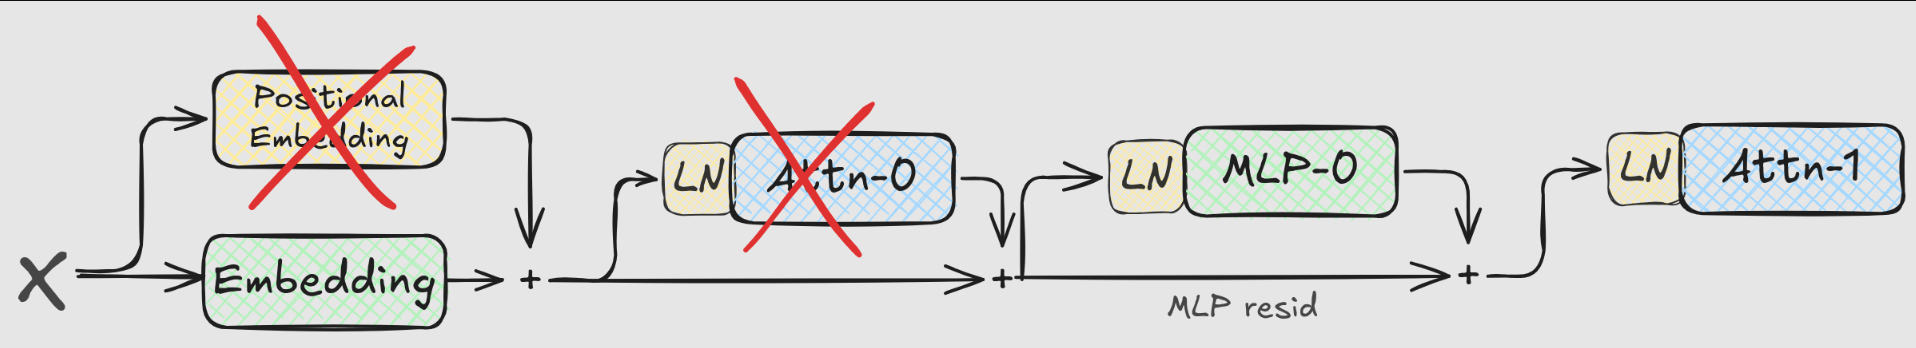

In [33]:
# use hooks to prevent the models access to non-essential inputs
# positional embedding zero ablation
def pos_embed_set_zero_hook(
    embed_output: Float[t.Tensor, "n_ctx d_model"],
    hook: HookPoint,
) -> Float[Tensor, "n_ctx d_model"]:

  print("Ablating pos embed!")
  return t.zeros_like(embed_output)

#'blocks.0.hook_attn_out'
# layer 0 attention result zero ablation
def attn_zero_hook(
    attn_result: Float[t.Tensor, "batch n_ctx d_model"],
    hook: HookPoint,
) -> Float[Tensor, "batch n_ctx d_model"]:

  print("Ablating attention out")
  return t.zeros_like(attn_result)

def get_attention_pattern_hook(
    attn_pattern: Float[t.Tensor, "batch heads seq_len seq_len"],
    hook: HookPoint,
) -> Float[Tensor, "batch heads seq_len seq_len"]:

  global layer_1_attn_pattern
  layer_1_attn_pattern = attn_pattern.squeeze()[5]
  print("getting L1")
  return attn_pattern

layer_1_attn_pattern = []
model.run_with_hooks(full_token_list, return_type = None, fwd_hooks = [('blocks.1.attn.hook_pattern', get_attention_pattern_hook), ('hook_pos_embed', pos_embed_set_zero_hook), ('blocks.0.hook_attn_out', attn_zero_hook)], reset_hooks_end = True, clear_contexts=True)
pos_and_attn0_attention_scores = layer_1_attn_pattern

Ablating pos embed!
torch.Size([1, 61, 768])
getting L1


In [24]:
print(layer_1_attn_pattern)

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9572, 0.0428, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9398, 0.0297, 0.0305,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5375, 0.0207, 0.0248,  ..., 0.0031, 0.0000, 0.0000],
        [0.2445, 0.0038, 0.0098,  ..., 0.0104, 0.0051, 0.0000],
        [0.2746, 0.0088, 0.0133,  ..., 0.0933, 0.0110, 0.0103]],
       grad_fn=<SelectBackward0>)


In [40]:
display_attention_pattern(pos_and_attn0_attention_scores.detach().numpy(), str_tokens, 1, 43, "L1H5 Attention Patterns (pos & attn0 ablated)")

### Observation:
Here we can see the semantically-similar word attention mechanism is still functioning as expected. However some tokens now have a much higher attention score than they did previously e.g. "dog cat horse bird fish pig" did not have high scores with "you he his she her their".
Looking at the previous non-ablated attention, we can observe that there was previously some attention here. This could indicate at a secondary purpose for the head which is supressed by the positional embedding or L0 attention.

We can test this by re-introducing each of these components and comparing the results.

In [39]:
# run model with positional embedding ablation
model.run_with_hooks(full_token_list, return_type = None, fwd_hooks = [('blocks.1.attn.hook_pattern', get_attention_pattern_hook), ('hook_pos_embed', pos_embed_set_zero_hook)], reset_hooks_end = True, clear_contexts=True)
pos_embed_ablated_attention_scores = layer_1_attn_pattern

# run model with attention layer 0 ablation
model.run_with_hooks(full_token_list, return_type = None, fwd_hooks = [('blocks.1.attn.hook_pattern', get_attention_pattern_hook), ('blocks.0.hook_attn_out', attn_zero_hook)], reset_hooks_end = True, clear_contexts=True)
l_zero_ablated_attention_scores = layer_1_attn_pattern

display_attention_pattern(pos_embed_ablated_attention_scores.detach().numpy(), str_tokens, 1, 43, "L1H5 Attention Patterns (pos ablated)")
display_attention_pattern(l_zero_ablated_attention_scores.detach().numpy(), str_tokens, 1, 43, "L1H5 Attention Patterns (attn 0 ablated)")

Ablating pos embed!
getting L1
torch.Size([1, 61, 768])
getting L1


In [27]:
print(layer_1_attn_pattern)

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9098, 0.0902, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2972, 0.5769, 0.1259,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0497, 0.0072, 0.0049,  ..., 0.0212, 0.0000, 0.0000],
        [0.0894, 0.0045, 0.0068,  ..., 0.0217, 0.0051, 0.0000],
        [0.0424, 0.0095, 0.0069,  ..., 0.1155, 0.0230, 0.0222]],
       grad_fn=<SelectBackward0>)


With this further investigation we can see that the L1H5 is still able to perform its function without positional embeddings and without L0 attention, validating our previous results.

# Part 3: The Mechanism of Self-Suppression

In order to re-create the results of this section, we need to graph the attention scores vs the cosine similarity of each token.
To find the similarity of each token, we will take a dot product of each of the tokens vector against each other token.


In [44]:
# take a dot product of each of the tokens vector against each other token.
# Get the token embeddings
token_embeddings = model.embed(full_token_list).squeeze(0)

# Calculate the cosine similarity between each token embedding and every other token embedding
# This can be done by normalizing the embeddings and then taking the dot product
normalized_embeddings = F.normalize(token_embeddings, p=2, dim=1)
cosine_similarity_matrix = normalized_embeddings @ normalized_embeddings.T

print(cosine_similarity_matrix.shape)
print(cosine_similarity_matrix)

torch.Size([61, 61])
tensor([[1.0000, 0.2349, 0.2608,  ..., 0.2388, 0.1764, 0.2008],
        [0.2349, 1.0000, 0.7088,  ..., 0.2132, 0.2436, 0.2019],
        [0.2608, 0.7088, 1.0000,  ..., 0.1818, 0.2333, 0.2016],
        ...,
        [0.2388, 0.2132, 0.1818,  ..., 1.0000, 0.3441, 0.3164],
        [0.1764, 0.2436, 0.2333,  ..., 0.3441, 1.0000, 0.3439],
        [0.2008, 0.2019, 0.2016,  ..., 0.3164, 0.3439, 1.0000]],
       grad_fn=<MmBackward0>)


In [56]:
# Extract L1H5 attention patterns (excluding the first token which is |endoftext|)
l1h5_attention = self_hate_attention_patterns[1:, 1:]

# Include the diagonal (self-attention) from both matrices
l1h5_attention_flat = l1h5_attention.flatten()
cosine_similarity_flat = cosine_similarity_matrix[1:, 1:].flatten()

# Calculate the logarithm of the attention scores, adding a small epsilon to avoid log(0)
log_l1h5_attention_flat = t.log(l1h5_attention_flat + 1e-3)

# Create a scatter plot
fig = px.scatter(x=cosine_similarity_flat.detach().numpy(),
                 y=log_l1h5_attention_flat.detach().numpy(),
                 labels={'x': 'Cosine Similarity', 'y': 'Log(L1H5 Attention Score)'},
                 title='Log(L1H5 Attention Score) vs Cosine Similarity (Including Self-Attention)')

fig.show()

In [57]:
# Discretize the cosine similarity into bins of size 0.02
bin_size = 0.02
# Determine the bin edges
min_sim = cosine_similarity_flat.min().item()
max_sim = cosine_similarity_flat.max().item()
bins = np.arange(min_sim, max_sim + bin_size, bin_size)

# Assign each data point to a bin
sim_bins = np.digitize(cosine_similarity_flat.detach().numpy(), bins)

# Create a pandas DataFrame to facilitate grouping and averaging
data_for_binning = pd.DataFrame({
    'cosine_similarity': cosine_similarity_flat.detach().numpy(),
    'log_attention_score': log_l1h5_attention_flat.detach().numpy(),
    'bin': sim_bins
})

# Calculate the average cosine similarity and average log attention score for each bin
binned_data = data_for_binning.groupby('bin').agg(
    avg_cosine_similarity=('cosine_similarity', 'mean'),
    avg_log_attention_score=('log_attention_score', 'mean')
).reset_index()

# Add a column for the bin label (e.g., '0.10 - 0.12')
binned_data['bin_label'] = binned_data['bin'].apply(lambda x: f"{bins[x-1]:.2f} - {bins[x]:.2f}")

# Print the binned data
print(binned_data)

    bin  avg_cosine_similarity  avg_log_attention_score    bin_label
0     1               0.133080                -5.588349  0.12 - 0.14
1     2               0.153932                -5.744234  0.14 - 0.16
2     3               0.174014                -5.924697  0.16 - 0.18
3     4               0.194176                -5.983789  0.18 - 0.20
4     5               0.213295                -5.992570  0.20 - 0.22
5     6               0.232915                -5.986948  0.22 - 0.24
6     7               0.253045                -6.015553  0.24 - 0.26
7     8               0.272263                -5.942946  0.26 - 0.28
8     9               0.291788                -5.930492  0.28 - 0.30
9    10               0.310775                -5.910102  0.30 - 0.32
10   11               0.331691                -5.628496  0.32 - 0.34
11   12               0.350532                -5.379609  0.34 - 0.36
12   13               0.373349                -5.299396  0.36 - 0.38
13   14               0.395254    

In [58]:
# Plot the binned data as a bar graph
fig = px.bar(binned_data,
             x='bin_label',
             y='avg_log_attention_score',
             labels={'bin_label': 'Cosine Similarity Range', 'avg_log_attention_score': 'Average Log(L1H5 Attention Score)'},
             title='Average Log(L1H5 Attention Score) by Cosine Similarity Range')

fig.update_layout(xaxis={'categoryorder':'category ascending'}) # Ensure bins are in order
fig.show()